# Exercises

#### 1. Try to build a classifier for the MNIST dataset that achieves over 97% accuracy on the test set. Hint: the KNeighborsClassifier works quite well for this task; you just need to find good hyperparameter values (try a grid search on the weights and n_neighbors hyperparameters).

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import StandardScaler
import seaborn as sns


In [2]:
# Fetch the MNIST dataset from OpenML
mnist = fetch_openml('mnist_784', version=1)

# Features and labels
X = mnist.data
y = mnist.target.astype(int)

# Check basic dataset information
print("Dataset shape (features, labels):", X.shape, y.shape)
print("First 5 rows of the features:")
print(X.head())
print("First 5 labels:")
print(y.head())

Dataset shape (features, labels): (70000, 784) (70000,)
First 5 rows of the features:
   pixel1  pixel2  pixel3  pixel4  pixel5  pixel6  pixel7  pixel8  pixel9  \
0       0       0       0       0       0       0       0       0       0   
1       0       0       0       0       0       0       0       0       0   
2       0       0       0       0       0       0       0       0       0   
3       0       0       0       0       0       0       0       0       0   
4       0       0       0       0       0       0       0       0       0   

   pixel10  ...  pixel775  pixel776  pixel777  pixel778  pixel779  pixel780  \
0        0  ...         0         0         0         0         0         0   
1        0  ...         0         0         0         0         0         0   
2        0  ...         0         0         0         0         0         0   
3        0  ...         0         0         0         0         0         0   
4        0  ...         0         0         0         0 

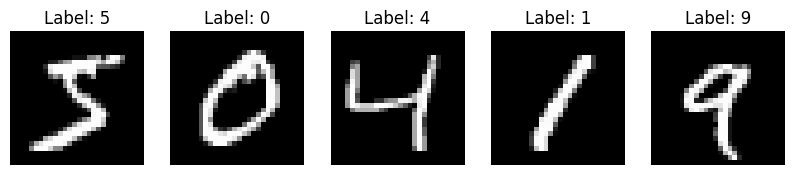

In [3]:
# Display the first 5 images in the dataset and their labels
fig, axes = plt.subplots(1, 5, figsize=(10, 5))
for i, ax in enumerate(axes):
    ax.imshow(X.iloc[i].values.reshape(28, 28), cmap='gray')  # Reshape the flat image back to 28x28
    ax.set_title(f"Label: {y[i]}")
    ax.axis('off')  # Hide the axis labels

plt.show()

In [4]:
# Split the dataset into training and testing sets (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [5]:
# Normalize the data using StandardScaler to improve KNN performance
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [6]:
# Define the KNN model
knn = KNeighborsClassifier()

# Define the hyperparameter grid for KNN
param_grid = {
    'n_neighbors': [3, 4, 5, 7, 9, 11, 13],
    'weights': ['uniform', 'distance']
}

# Perform grid search with cross-validation to find the best hyperparameters
grid_search = GridSearchCV(estimator=knn, param_grid=param_grid, cv=5, n_jobs=-1, verbose=1)
grid_search.fit(X_train, y_train)

# Print the best hyperparameters found
print("Best hyperparameters found:", grid_search.best_params_)

Fitting 5 folds for each of 14 candidates, totalling 70 fits
Best hyperparameters found: {'n_neighbors': 4, 'weights': 'distance'}


In [7]:
# Get the best model based on the grid search
best_knn = grid_search.best_estimator_

# Make predictions on the test set
y_pred = best_knn.predict(X_test)

# Calculate the accuracy of the model on the test set
accuracy = accuracy_score(y_test, y_pred)
print("Test set accuracy: {:.2f}%".format(accuracy * 100))

Test set accuracy: 94.86%


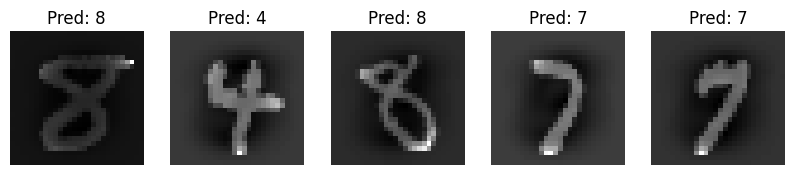

In [8]:
# Display a few images and their predicted labels
fig, axes = plt.subplots(1, 5, figsize=(10, 5))
for i, ax in enumerate(axes):
    ax.imshow(X_test[i].reshape(28, 28), cmap='gray')  # Reshape the flat image back to 28x28
    ax.set_title(f"Pred: {y_pred[i]}")  # Display the predicted label
    ax.axis('off')  # Hide the axis labels

plt.show()

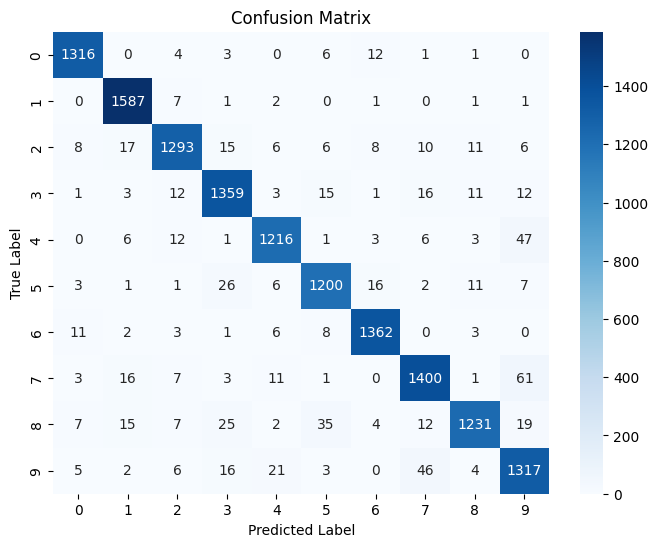

In [9]:
# Generate the confusion matrix
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_test, y_pred)

# Plot the confusion matrix as a heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=np.arange(10), yticklabels=np.arange(10))
plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

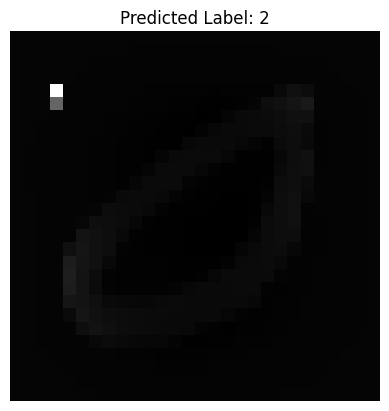

In [10]:
# Classify a random image from the test set (Good practice)
random_index = np.random.randint(0, X_test.shape[0])
random_image = X_test[random_index].reshape(28, 28)

# Display the random image and its prediction
plt.imshow(random_image, cmap='gray')
plt.title(f"Predicted Label: {y_pred[random_index]}")
plt.axis('off')
plt.show()

#### 2.  Write a function that can shift an MNIST image in any direction (left, right, up, or down) by one pixel. Then, for each image in the training set, create four shifted copies (one per direction) and add them to the training set. Finally, train your best model on this expanded training set and measure its accuracy on the test set. You should observe that your model performs even better now! This technique of artificially growing the training set is called data augmentation or training set expansion.

In [11]:
def shift_image(image, dx, dy):
    """Shift an MNIST image by dx (horizontal) and dy (vertical)"""
    image = image.reshape(28, 28)
    shifted_image = np.roll(image, shift=dy, axis=0)  # vertical shift
    shifted_image = np.roll(shifted_image, shift=dx, axis=1)  # horizontal shift

    # Zero out wrapped values
    if dy > 0:
        shifted_image[:dy, :] = 0
    elif dy < 0:
        shifted_image[dy:, :] = 0
    if dx > 0:
        shifted_image[:, :dx] = 0
    elif dx < 0:
        shifted_image[:, dx:] = 0

    return shifted_image.flatten()

In [12]:
# Create shifted copies in four directions for data augmentation
X_train_augmented = [X_train]
y_train_augmented = [y_train]

for dx, dy in ((1,0), (-1,0), (0,1), (0,-1)):  # right, left, down, up
    shifted = np.apply_along_axis(shift_image, 1, X_train, dx, dy)
    X_train_augmented.append(shifted)
    y_train_augmented.append(y_train)

# Concatenate all together
X_train_augmented = np.concatenate(X_train_augmented)
y_train_augmented = np.concatenate(y_train_augmented)

print("Augmented training shape:", X_train_augmented.shape)

Augmented training shape: (280000, 784)


In [13]:
# Train on augmented dataset
best_knn.fit(X_train_augmented, y_train_augmented)

,n_neighbors,4
,weights,'distance'
,algorithm,'auto'
,leaf_size,30
,p,2
,metric,'minkowski'
,metric_params,None
,n_jobs,None


In [14]:
# Predict on the TEST SET after training with the augmented dataset
y_pred = best_knn.predict(X_test)


In [15]:
# Measure accuracy using TEST labels
accuracy = accuracy_score(y_test, y_pred)
print(f"Test set accuracy with data augmentation using KNN: {accuracy:.4f}")

Test set accuracy with data augmentation using KNN: 0.9588


#### 3. Tackle the Titanic dataset. A great place to start is on Kaggle

In [16]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score


In [17]:
# Load Titanic dataset directly from seaborn
titanic = sns.load_dataset('titanic')

# Preview
print(titanic.head())

   survived  pclass     sex   age  sibsp  parch     fare embarked  class  \
0         0       3    male  22.0      1      0   7.2500        S  Third   
1         1       1  female  38.0      1      0  71.2833        C  First   
2         1       3  female  26.0      0      0   7.9250        S  Third   
3         1       1  female  35.0      1      0  53.1000        S  First   
4         0       3    male  35.0      0      0   8.0500        S  Third   

     who  adult_male deck  embark_town alive  alone  
0    man        True  NaN  Southampton    no  False  
1  woman       False    C    Cherbourg   yes  False  
2  woman       False  NaN  Southampton   yes   True  
3  woman       False    C  Southampton   yes  False  
4    man        True  NaN  Southampton    no   True  


In [18]:
# Basic info
print(titanic.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 15 columns):
 #   Column       Non-Null Count  Dtype   
---  ------       --------------  -----   
 0   survived     891 non-null    int64   
 1   pclass       891 non-null    int64   
 2   sex          891 non-null    object  
 3   age          714 non-null    float64 
 4   sibsp        891 non-null    int64   
 5   parch        891 non-null    int64   
 6   fare         891 non-null    float64 
 7   embarked     889 non-null    object  
 8   class        891 non-null    category
 9   who          891 non-null    object  
 10  adult_male   891 non-null    bool    
 11  deck         203 non-null    category
 12  embark_town  889 non-null    object  
 13  alive        891 non-null    object  
 14  alone        891 non-null    bool    
dtypes: bool(2), category(2), float64(2), int64(4), object(5)
memory usage: 80.7+ KB
None


In [19]:
print(titanic.describe())

         survived      pclass         age       sibsp       parch        fare
count  891.000000  891.000000  714.000000  891.000000  891.000000  891.000000
mean     0.383838    2.308642   29.699118    0.523008    0.381594   32.204208
std      0.486592    0.836071   14.526497    1.102743    0.806057   49.693429
min      0.000000    1.000000    0.420000    0.000000    0.000000    0.000000
25%      0.000000    2.000000   20.125000    0.000000    0.000000    7.910400
50%      0.000000    3.000000   28.000000    0.000000    0.000000   14.454200
75%      1.000000    3.000000   38.000000    1.000000    0.000000   31.000000
max      1.000000    3.000000   80.000000    8.000000    6.000000  512.329200


In [20]:
# Fill missing 'age' values with the median
titanic['age'] = titanic['age'].fillna(titanic['age'].median())

# Fill missing 'embarked' values with the mode
titanic['embarked'] = titanic['embarked'].fillna(titanic['embarked'].mode()[0])

In [21]:
# Map 'sex' to 0 (male) and 1 (female)
titanic['sex'] = titanic['sex'].map({'male': 0, 'female': 1})

# Map 'embarked' to 0 (S), 1 (C), 2 (Q)
titanic['embarked'] = titanic['embarked'].map({'S': 0, 'C': 1, 'Q': 2})

In [22]:
# Select features to train
features = ['pclass', 'sex', 'age', 'sibsp', 'parch', 'fare', 'embarked']

# Set X and y
X = titanic[features]
y = titanic['survived']

In [23]:
# Check if any NaNs remain before training
print(X.isnull().sum())


pclass      0
sex         0
age         0
sibsp       0
parch       0
fare        0
embarked    0
dtype: int64


In [24]:
# Split the dataset for training and validation
X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.2, random_state=42
)

In [25]:
# Initialize and train the Logistic Regression model
model = LogisticRegression(max_iter=500)
model.fit(X_train, y_train)

,penalty,'l2'
,dual,False
,tol,0.0001
,C,1.0
,fit_intercept,True
,intercept_scaling,1
,class_weight,None
,random_state,None
,solver,'lbfgs'
,max_iter,500
,multi_class,'deprecated'


In [26]:
# Predict on the validation set
y_pred = model.predict(X_val)

# Print the validation accuracy
print("Validation Accuracy:", accuracy_score(y_val, y_pred))

Validation Accuracy: 0.7988826815642458


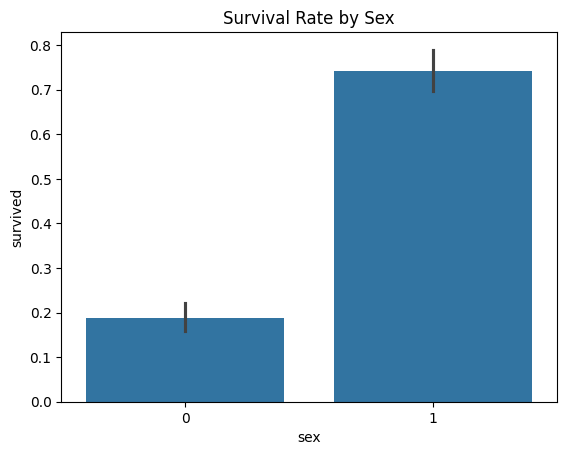

In [27]:
# Plot survival rate by sex for quick insight
sns.barplot(x='sex', y='survived', data=titanic)
plt.title('Survival Rate by Sex')
plt.show()

#### 4. Build a spam classifier (a more challenging exercise):
#### • Download examples of spam and ham from Apache SpamAssassin’s public datasets.
#### • Unzip the datasets and familiarize yourself with the data format.
#### • Split the datasets into a training set and a test set.
#### • Write a data preparation pipeline to convert each email into a feature vector.
#### Your preparation pipeline should transform an email into a (sparse) vector indicating the presence or absence of each possible word. For example, if all emails only ever contain four words, “Hello,” “how,” “are,” “you,” then the email “Hello you Hello Hello you” would be converted into a vector [1, 0, 0, 1] (meaning [“Hello” is present, “how” is absent, “are” is absent, “you” is present]), or [3, 0, 0, 2] if you prefer to count the number of occurrences of each word.
#### • You may want to add hyperparameters to your preparation pipeline to control whether or not to strip off email headers, convert each email to lowercase, remove punctuation, replace all URLs with “URL,” replace all numbers with “NUMBER,” or even perform stemming (i.e., trim off word endings; there are Python libraries available to do this).
#### • Then try out several classifiers and see if you can build a great spam classifier, with both high recall and high precision

#### • Download examples of spam and ham from Apache SpamAssassin’s public datasets.

In [28]:
import os
import urllib.request

In [29]:
# URLs of the datasets
SPAM_URL = "https://spamassassin.apache.org/old/publiccorpus/20030228_spam.tar.bz2"
HAM_URL = "https://spamassassin.apache.org/old/publiccorpus/20030228_easy_ham.tar.bz2"

In [30]:
# Function to download datasets
def download_file(url, destination_folder):
    """
    Downloads a file from a URL into the specified destination folder.
    """
    os.makedirs(destination_folder, exist_ok=True)
    filename = os.path.basename(url)
    file_path = os.path.join(destination_folder, filename)

    if not os.path.exists(file_path):
        print(f"Downloading {filename}...")
        urllib.request.urlretrieve(url, file_path)
        print(f"Downloaded {filename} to {file_path}")
    else:
        print(f"{filename} already exists at {file_path}")

    return file_path

In [31]:
# Download files
spam_file_path = download_file(SPAM_URL, "../data")
ham_file_path = download_file(HAM_URL, "../data")

20030228_spam.tar.bz2 already exists at ../data\20030228_spam.tar.bz2
20030228_easy_ham.tar.bz2 already exists at ../data\20030228_easy_ham.tar.bz2


#### • Unzip the datasets and familiarize yourself with the data format.

In [32]:
import tarfile
from email import policy
from email.parser import BytesParser

In [33]:
def extract_tar_bz2(file_path, extract_to):
    """
    Extracts a .tar.bz2 file to the specified destination folder.
    Returns the full path to the extracted main folder inside the archive.
    """
    os.makedirs(extract_to, exist_ok=True)

    print(f"Extracting {file_path} to {extract_to}...")
    with tarfile.open(file_path, "r:bz2") as tar:
        tar.extractall(path=extract_to)
        # Get the top-level directory/folder from the archive
        top_level_dirs = {name.split('/')[0] for name in tar.getnames() if '/' in name}
    
    print("Extraction completed.")

    if top_level_dirs:
        extracted_path = os.path.join(extract_to, top_level_dirs.pop())
        return os.path.abspath(extracted_path)
    else:
        return os.path.abspath(extract_to)

# Extract datasets
spam_dir = extract_tar_bz2(spam_file_path, "../data")
ham_dir = extract_tar_bz2(ham_file_path, "../data")

Extracting ../data\20030228_spam.tar.bz2 to ../data...
Extraction completed.
Extracting ../data\20030228_easy_ham.tar.bz2 to ../data...
Extraction completed.


In [34]:
# List some files in each extracted folder
def list_files(directory, n=5):
    """
    Lists the first n files in the given directory.
    """
    files = os.listdir(directory)
    print(f"\nFirst {n} files in {directory}:")
    for file in files[:n]:
        print(file)

list_files(spam_dir)
list_files(ham_dir)


First 5 files in c:\Books\Hands_On_Machine_Learning_with_Scikit_Learn_and_TensorFlow\Chapter_3\data\spam:
00001.7848dde101aa985090474a91ec93fcf0
00002.d94f1b97e48ed3b553b3508d116e6a09
00003.2ee33bc6eacdb11f38d052c44819ba6c
00004.eac8de8d759b7e74154f142194282724
00005.57696a39d7d84318ce497886896bf90d

First 5 files in c:\Books\Hands_On_Machine_Learning_with_Scikit_Learn_and_TensorFlow\Chapter_3\data\easy_ham:
00001.7c53336b37003a9286aba55d2945844c
00002.9c4069e25e1ef370c078db7ee85ff9ac
00003.860e3c3cee1b42ead714c5c874fe25f7
00004.864220c5b6930b209cc287c361c99af1
00005.bf27cdeaf0b8c4647ecd61b1d09da613


In [35]:
def explore_email_format(email_path):
    """
    Displays the raw content, headers, and structure of an email file.
    """
    print(f"Exploring file: {email_path}\n")

    # Display raw content
    with open(email_path, 'r', encoding='latin1') as f:
        raw_content = f.read()
    print("=== Raw Email Content (first 500 characters) ===")
    print(raw_content[:1000])
    print('\n' + '-'*60 + '\n')

    # Parse the email
    with open(email_path, 'rb') as f:
        msg = BytesParser(policy=policy.default).parse(f)

    # Display headers
    print("=== Email Headers ===")
    for key, value in msg.items():
        print(f"{key}: {value}")

    # Explore structure
    print("\n=== Email Structure ===")
    if msg.is_multipart():
        for i, part in enumerate(msg.walk()):
            print(f"Part {i}: content type = {part.get_content_type()}, charset = {part.get_content_charset()}")
    else:
        print(f"Single part: content type = {msg.get_content_type()}, charset = {msg.get_content_charset()}")

# Example usage with a sample spam and ham email
sample_spam_path = os.path.join(spam_dir, os.listdir(spam_dir)[0])
sample_ham_path = os.path.join(ham_dir, os.listdir(ham_dir)[0])


In [36]:
print("\n--- Spam Email Sample ---\n")
explore_email_format(sample_spam_path)


--- Spam Email Sample ---

Exploring file: c:\Books\Hands_On_Machine_Learning_with_Scikit_Learn_and_TensorFlow\Chapter_3\data\spam\00001.7848dde101aa985090474a91ec93fcf0

=== Raw Email Content (first 500 characters) ===
From 12a1mailbot1@web.de  Thu Aug 22 13:17:22 2002
Return-Path: <12a1mailbot1@web.de>
Delivered-To: zzzz@localhost.spamassassin.taint.org
Received: from localhost (localhost [127.0.0.1])
	by phobos.labs.spamassassin.taint.org (Postfix) with ESMTP id 136B943C32
	for <zzzz@localhost>; Thu, 22 Aug 2002 08:17:21 -0400 (EDT)
Received: from mail.webnote.net [193.120.211.219]
	by localhost with POP3 (fetchmail-5.9.0)
	for zzzz@localhost (single-drop); Thu, 22 Aug 2002 13:17:21 +0100 (IST)
Received: from dd_it7 ([210.97.77.167])
	by webnote.net (8.9.3/8.9.3) with ESMTP id NAA04623
	for <zzzz@spamassassin.taint.org>; Thu, 22 Aug 2002 13:09:41 +0100
From: 12a1mailbot1@web.de
Received: from r-smtp.korea.com - 203.122.2.197 by dd_it7  with Microsoft SMTPSVC(5.5.1775.675.6);
	 Sat,

In [37]:
print("\n--- Ham Email Sample ---\n")
explore_email_format(sample_ham_path)


--- Ham Email Sample ---

Exploring file: c:\Books\Hands_On_Machine_Learning_with_Scikit_Learn_and_TensorFlow\Chapter_3\data\easy_ham\00001.7c53336b37003a9286aba55d2945844c

=== Raw Email Content (first 500 characters) ===
From exmh-workers-admin@redhat.com  Thu Aug 22 12:36:23 2002
Return-Path: <exmh-workers-admin@spamassassin.taint.org>
Delivered-To: zzzz@localhost.netnoteinc.com
Received: from localhost (localhost [127.0.0.1])
	by phobos.labs.netnoteinc.com (Postfix) with ESMTP id D03E543C36
	for <zzzz@localhost>; Thu, 22 Aug 2002 07:36:16 -0400 (EDT)
Received: from phobos [127.0.0.1]
	by localhost with IMAP (fetchmail-5.9.0)
	for zzzz@localhost (single-drop); Thu, 22 Aug 2002 12:36:16 +0100 (IST)
Received: from listman.spamassassin.taint.org (listman.spamassassin.taint.org [66.187.233.211]) by
    dogma.slashnull.org (8.11.6/8.11.6) with ESMTP id g7MBYrZ04811 for
    <zzzz-exmh@spamassassin.taint.org>; Thu, 22 Aug 2002 12:34:53 +0100
Received: from listman.spamassassin.taint.org (

In [38]:
# Load and parse one sample email
def load_email(file_path):
    """
    Loads an email file and parses it using the default email policy.
    """
    with open(file_path, 'rb') as f:
        return BytesParser(policy=policy.default).parse(f)

# Example: parse a spam email
sample_spam_file = os.path.join(spam_dir, os.listdir(spam_dir)[0])
sample_spam_email = load_email(sample_spam_file)

print("\n=== Example of Raw Email Content (Spam) ===\n")
print(sample_spam_email)


=== Example of Raw Email Content (Spam) ===

Return-Path: <12a1mailbot1@web.de>
Delivered-To: zzzz@localhost.spamassassin.taint.org
Received: from localhost (localhost [127.0.0.1])
	by phobos.labs.spamassassin.taint.org (Postfix) with ESMTP id 136B943C32
	for <zzzz@localhost>; Thu, 22 Aug 2002 08:17:21 -0400 (EDT)
Received: from mail.webnote.net [193.120.211.219]
	by localhost with POP3 (fetchmail-5.9.0)
	for zzzz@localhost (single-drop); Thu, 22 Aug 2002 13:17:21 +0100 (IST)
Received: from dd_it7 ([210.97.77.167])
	by webnote.net (8.9.3/8.9.3) with ESMTP id NAA04623
	for <zzzz@spamassassin.taint.org>; Thu, 22 Aug 2002 13:09:41 +0100
From: 12a1mailbot1@web.de
Received: from r-smtp.korea.com - 203.122.2.197 by dd_it7  with Microsoft
 SMTPSVC(5.5.1775.675.6);	 Sat, 24 Aug 2002 09:42:10 +0900
To: <dcek1a1@netsgo.com>
Subject: Life Insurance - Why Pay More?
Date: Wed, 21 Aug 2002 20:31:57 -1600
MIME-Version: 1.0
Message-ID: <0103c1042001882DD_IT7@dd_it7>
Content-Type: text/html; charset="

In [39]:
# Extract html text body from the email
def extract_html_text(email_message):
    """
    Extracts the HTML content from an email message.
    Handles unknown or invalid charset by falling back to utf-8 with errors ignored.
    """
    for part in email_message.walk():
        if part.get_content_type() == "text/html":
            try:
                return part.get_content()
            except LookupError:
                payload = part.get_payload(decode=True)
                if payload:
                    return payload.decode('utf-8', errors='ignore')
    return ""


html_text = extract_html_text(sample_spam_email)

print("\n=== HTML Text Content of the Email ===\n")
print(html_text)


=== HTML Text Content of the Email ===

<!DOCTYPE HTML PUBLIC "-//W3C//DTD HTML 4.0 Transitional//EN">
<HTML><HEAD>
<META content="text/html; charset=windows-1252" http-equiv=Content-Type>
<META content="MSHTML 5.00.2314.1000" name=GENERATOR></HEAD>
<BODY><!-- Inserted by Calypso -->
<TABLE border=0 cellPadding=0 cellSpacing=2 id=_CalyPrintHeader_ rules=none 
style="COLOR: black; DISPLAY: none" width="100%">
  <TBODY>
  <TR>
    <TD colSpan=3>
      <HR color=black noShade SIZE=1>
    </TD></TR></TD></TR>
  <TR>
    <TD colSpan=3>
      <HR color=black noShade SIZE=1>
    </TD></TR></TBODY></TABLE><!-- End Calypso --><!-- Inserted by Calypso --><FONT 
color=#000000 face=VERDANA,ARIAL,HELVETICA size=-2><BR></FONT></TD></TR></TABLE><!-- End Calypso --><FONT color=#ff0000 
face="Copperplate Gothic Bold" size=5 PTSIZE="10">
<CENTER>Save up to 70% on Life Insurance.</CENTER></FONT><FONT color=#ff0000 
face="Copperplate Gothic Bold" size=5 PTSIZE="10">
<CENTER>Why Spend More Than You Have T

In [40]:
# Extract plain text body from the email
def extract_plain_text(email_message):
    """
    Extracts the plain text content from an email message.
    Handles unknown or invalid charset by falling back to utf-8 with errors ignored.
    """
    for part in email_message.walk():
        if part.get_content_type() == "text/plain":
            try:
                return part.get_content()
            except LookupError:
                # Fallback manual decoding
                payload = part.get_payload(decode=True)
                if payload:
                    return payload.decode('utf-8', errors='ignore')
    return ""


plain_text = extract_plain_text(sample_spam_email)

print("\n=== Plain Text Content of the Email ===\n")
print(plain_text)


=== Plain Text Content of the Email ===




#### • Split the datasets into a training set and a test set.

In [41]:
from sklearn.model_selection import train_test_split
import numpy as np

In [42]:
def load_emails_from_dir(directory):
    """
    Loads all email messages from a directory.
    """
    emails = []
    filenames = os.listdir(directory)
    for filename in filenames:
        path = os.path.join(directory, filename)
        if os.path.isfile(path):
            with open(path, 'rb') as f:
                try:
                    msg = BytesParser(policy=policy.default).parse(f)
                    emails.append(msg)
                except:
                    pass  # Skip if email parsing fails
    return emails

In [43]:
import re

def extract_text(email_message):
    """
    Extracts plain text from an email.
    If not available, extracts HTML content as fallback.
    """
    text = extract_plain_text(email_message)
    if not text.strip():
        html_content = extract_html_text(email_message)
        if html_content.strip():
            # Remove HTML tags if needed (simple regex)
            text = re.sub('<[^<]+?>', '', html_content)
    return text

In [44]:
# Load emails
spam_emails = load_emails_from_dir(spam_dir)
ham_emails = load_emails_from_dir(ham_dir)

In [45]:
# Extract text and create dataset
spam_texts = [extract_text(email) for email in spam_emails]
ham_texts = [extract_text(email) for email in ham_emails]

In [46]:
X = spam_texts + ham_texts
y = np.array([1]*len(spam_texts) + [0]*len(ham_texts))

# Split into train and test sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print(f"Training set size: {len(X_train)}")
print(f"Test set size: {len(X_test)}")

Training set size: 2401
Test set size: 601


In [47]:
print("First raw email text (before preprocessing):")
print(X_train[0])

First raw email text (before preprocessing):
Once upon a time, Julian wrote :

> I would appreciate it if you could get Gabber packages for Red Hat 8. I 
> will be making a new release soon, but even in the meantime, 0.8.7 
> packages would be ok.
> 
> I know that in the beta, red hat was using a modified version of 
> gnome-libs which is incompatible with the latest gnomemm. If this is 
> still the case in 8, I can send you a patch which makes gnomemm work 
> again...

I'm facing another problem right now. It looks like libsigc++ is no longer
included in the distribution, and gtkmm won't compile without it :-/
I guess I'll have to repackage it myself for 8.0 (assuming it's possible).

Matthias

-- 
Clean custom Red Hat Linux rpm packages : http://freshrpms.net/
Red Hat Linux release 7.3 (Valhalla) running Linux kernel 2.4.18-10acpi
Load : 0.28 0.15 0.10

_______________________________________________
RPM-List mailing list <RPM-List@freshrpms.net>
http://lists.freshrpms.net/mailman/li

#### • Write a data preparation pipeline to convert each email into a feature vector.

#### • You may want to add hyperparameters to your preparation pipeline to control whether or not to strip off email headers, convert each email to lowercase, remove punctuation, replace all URLs with “URL,” replace all numbers with “NUMBER,” or even perform stemming (i.e., trim off word endings; there are Python libraries available to do this).

In [48]:
from sklearn.feature_extraction.text import CountVectorizer

In [49]:
def preprocess_text(text):
    """
    Preprocesses email text:
    - Lowercase
    - Replace URLs and numbers
    - Remove punctuation and non-alphanumeric characters
    - Normalize spaces
    """
    text = text.lower()
    text = re.sub(r'http\S+', ' URL ', text)
    text = re.sub(r'\d+', ' NUMBER ', text)
    text = re.sub(r'[^a-z\s]', ' ', text)  # Keep only letters and spaces
    text = re.sub(r'\s+', ' ', text)
    return text.strip()


# Preprocess training and test data
X_train_clean = [preprocess_text(text) for text in X_train]
X_test_clean = [preprocess_text(text) for text in X_test]

In [50]:
for i, text in enumerate(X_train_clean[:5]):
    print(f"\nPreprocessed text {i}:\n{text}")


Preprocessed text 0:
once upon a time julian wrote i would appreciate it if you could get gabber packages for red hat i will be making a new release soon but even in the meantime packages would be ok i know that in the beta red hat was using a modified version of gnome libs which is incompatible with the latest gnomemm if this is still the case in i can send you a patch which makes gnomemm work again i m facing another problem right now it looks like libsigc is no longer included in the distribution and gtkmm won t compile without it i guess i ll have to repackage it myself for assuming it s possible matthias clean custom red hat linux rpm packages red hat linux release valhalla running linux kernel acpi load rpm list mailing list rpm list freshrpms net

Preprocessed text 1:
friend now you can copy dvd s and games backup dvd video s with your cd r burner with studio s software you can now copy any dvd and playstation game never buy another backup dvd movie again just copy it this is t

In [51]:
def vectorize_texts(texts, vectorizer=None, binary=False):
    """
    Vectorizes the given texts using CountVectorizer.
    If binary=True, encodes presence/absence (1 or 0).
    If binary=False, encodes word counts.
    """
    if vectorizer is None:
        vectorizer = CountVectorizer(binary=True, stop_words='english', token_pattern=r'\b[a-z]{2,20}\b')

        vectors = vectorizer.fit_transform(texts)
    else:
        vectors = vectorizer.transform(texts)
    return vectors, vectorizer

# Example: presence/absence of words
X_train_vec, vectorizer = vectorize_texts(X_train_clean, binary=True)
X_test_vec, _ = vectorize_texts(X_test_clean, vectorizer=vectorizer, binary=True)

In [52]:
print(f"Vocabulary size: {len(vectorizer.get_feature_names_out())}")
print(f"Feature vector shape (train): {X_train_vec.shape}")
print(f"Feature vector shape (test): {X_test_vec.shape}")

Vocabulary size: 38516
Feature vector shape (train): (2401, 38516)
Feature vector shape (test): (601, 38516)


#### • Then try out several classifiers and see if you can build a great spam classifier, with both high recall and high precision.

In [53]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

In [54]:
# Define classifiers
classifiers = {
    'Naive Bayes': MultinomialNB(),
    'Logistic Regression': LogisticRegression(max_iter=1000),
    'SVM': SVC()
}


=== Naive Bayes ===
              precision    recall  f1-score   support

         Ham       0.97      1.00      0.98       501
        Spam       1.00      0.83      0.91       100

    accuracy                           0.97       601
   macro avg       0.98      0.92      0.95       601
weighted avg       0.97      0.97      0.97       601



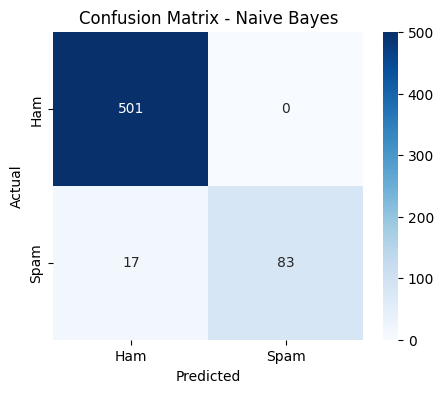


=== Logistic Regression ===
              precision    recall  f1-score   support

         Ham       0.98      1.00      0.99       501
        Spam       0.99      0.90      0.94       100

    accuracy                           0.98       601
   macro avg       0.98      0.95      0.97       601
weighted avg       0.98      0.98      0.98       601



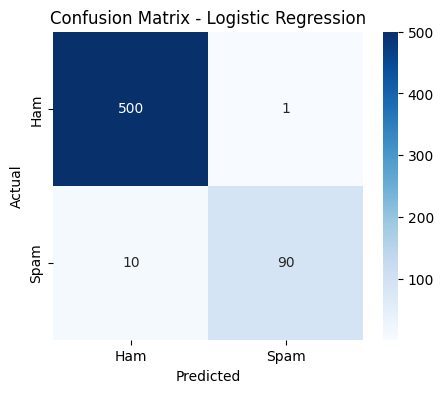


=== SVM ===
              precision    recall  f1-score   support

         Ham       0.96      1.00      0.98       501
        Spam       1.00      0.81      0.90       100

    accuracy                           0.97       601
   macro avg       0.98      0.91      0.94       601
weighted avg       0.97      0.97      0.97       601



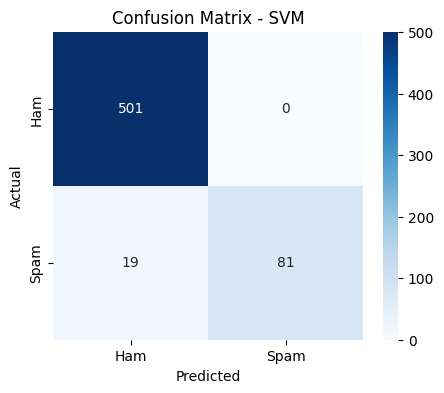

In [55]:
# Train, predict and evaluate
for name, clf in classifiers.items():
    print(f"\n=== {name} ===")
    clf.fit(X_train_vec, y_train)
    y_pred = clf.predict(X_test_vec)
    
    # Classification metrics
    print(classification_report(y_test, y_pred, target_names=['Ham', 'Spam']))

    # Confusion Matrix
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(5,4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Ham', 'Spam'], yticklabels=['Ham', 'Spam'])
    plt.title(f'Confusion Matrix - {name}')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()